In [6]:
#auto reload 
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import numpy as np
import os 
from datasets import load_dataset


c:\Users\Alhus\.conda\envs\mlaproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
wmt14 = load_dataset("wmt14", "fr-en", data_dir="data/")

# Accessing example data
train_data = wmt14["train"]
val_data = wmt14["validation"]


In [27]:
from src.utils.plotting import plot_alignment 
import numpy as np
english_ex = ["The" , "Cat", "Sat", "On", "The", "Mat"]
french_ex = ["Le", "Chat", "S'est", "Assis", "Sur", "Le", "Tapis"]

alignment = np.random.rand( len(french_ex),len(english_ex))
data = {"Chat": (english_ex, french_ex, alignment),"Chaton": (english_ex, french_ex, alignment), "Chien": (english_ex, french_ex, alignment), "Chiot": (english_ex, french_ex, alignment)}

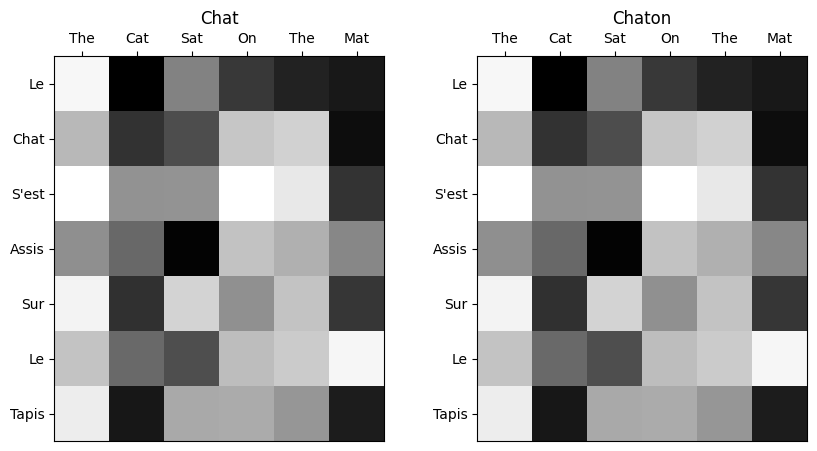

In [28]:
plot_alignment(data)